In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN , Input,Flatten, LSTM
from tensorflow.keras import backend as K
from keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

2025-03-19 02:27:18.534603: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 02:27:18.536793: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 02:27:18.542491: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 02:27:18.558437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742376438.589939 3226941 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742376438.59

In [2]:
import os
import pandas as pd

opened = []

csv_path = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/'
masterlist = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/ALL_STATIONS_FINAL_REVISED.csv'

# Load the master list of stations
stations_df = pd.read_csv(masterlist)

# Extract station numbers, areas, and latitudes
station_num = stations_df['grdc_no']
station_area = stations_df['area']
station_lat = stations_df['lat']

# Map station numbers to areas and latitudes
station_area_map = dict(zip(station_num, station_area))
station_lat_map = dict(zip(station_num, station_lat))

# Generate the list of file paths
arrayFile = [os.path.join(csv_path, f"{station_no}.csv") for station_no in station_num]

# Initialize a list to store opened DataFrames
for file in arrayFile:
    station_no = os.path.basename(file).split('.')[0]  # Extract station number from the filename
    if os.path.exists(file):  # Check if file exists
        df = pd.read_csv(file, index_col=None, header=0)
        station_no_int = int(station_no)  # Convert station number to integer for lookup
        df['GRDC_No'] = station_no_int  # Add the station number as a new column
        df['Area'] = station_area_map.get(station_no_int, None)  # Add the Area column
        df['Latitude'] = station_lat_map.get(station_no_int, None)  # Add the latitude column
        opened.append(df)

# Combine all DataFrames into one
total_df = pd.concat(opened, axis=0, ignore_index=True)

# Print or save the resulting DataFrame
print(total_df.head())


   Unnamed: 0     Date       Q       SWE   SWE_scaled  GRDC_No      Area  \
0           0  2018-08  24.526  2.087791  1809042.021  1159100  866486.0   
1           1  2018-09  31.372  1.835435  1590378.590  1159100  866486.0   
2           2  2018-10  19.572  1.976332  1712463.856  1159100  866486.0   
3           3  2018-11   7.349  1.633273  1415208.035  1159100  866486.0   
4           4  2018-12  13.824  1.782850  1544814.625  1159100  866486.0   

   Latitude  
0 -28.75799  
1 -28.75799  
2 -28.75799  
3 -28.75799  
4 -28.75799  


In [3]:
q = total_df['Q']
swe = total_df['SWE']
scaled = total_df['SWE_scaled']/100
area = total_df['Area']
station = total_df['GRDC_No']
lat = total_df['Latitude']

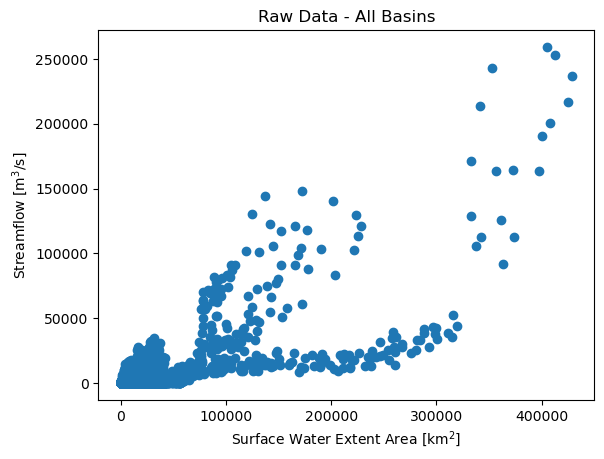

In [4]:
plt.scatter(scaled,q)
plt.title('Raw Data - All Basins')
plt.xlabel('Surface Water Extent Area [km${^2}$]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

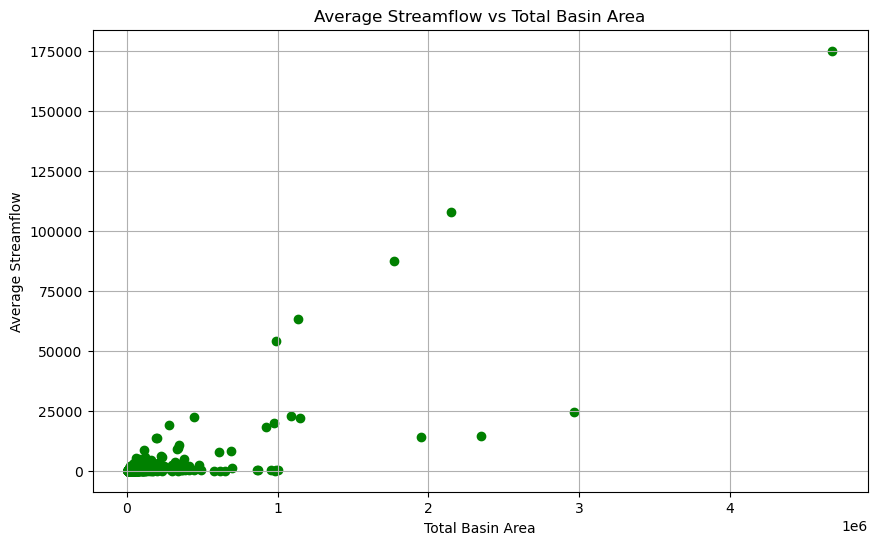

In [5]:
grouped = total_df.groupby('Area')['Q'].mean()

# Extract unique areas and their corresponding average Q values
area_unique = grouped.index
q_avg = grouped.values

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(area_unique, q_avg, color='g')
plt.xlabel('Total Basin Area')
plt.ylabel('Average Streamflow')
plt.title('Average Streamflow vs Total Basin Area')
plt.grid(True)
plt.show()

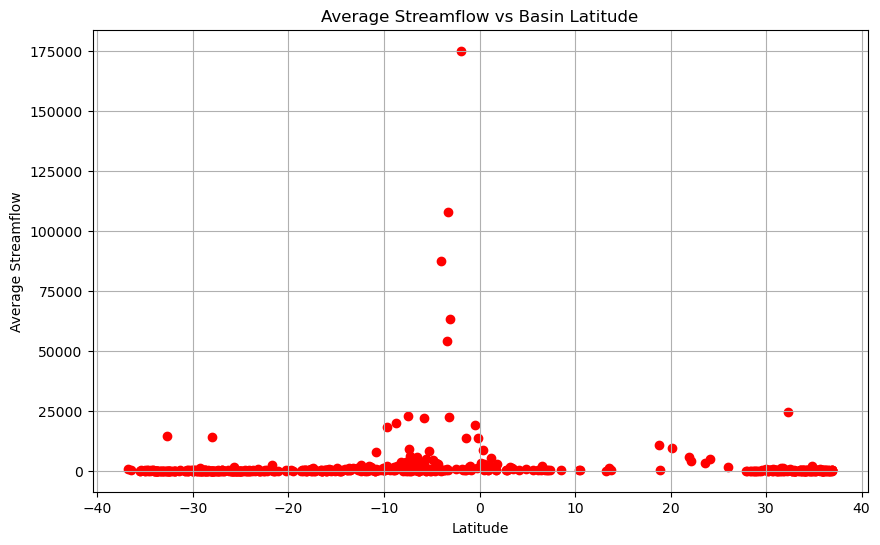

In [6]:
grouped = total_df.groupby('Latitude')['Q'].mean()

# Extract unique areas and their corresponding average Q values
lat_unique = grouped.index
q_avg = grouped.values

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(lat_unique, q_avg,color='red')
plt.xlabel('Latitude')
plt.ylabel('Average Streamflow')
plt.title('Average Streamflow vs Basin Latitude')
plt.grid(True)
plt.show()

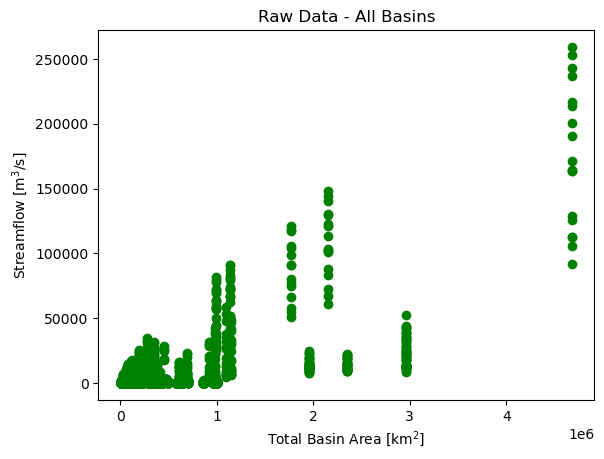

In [7]:
plt.scatter(area,q,color='g')
plt.title('Raw Data - All Basins')
plt.xlabel('Total Basin Area [km${^2}$]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

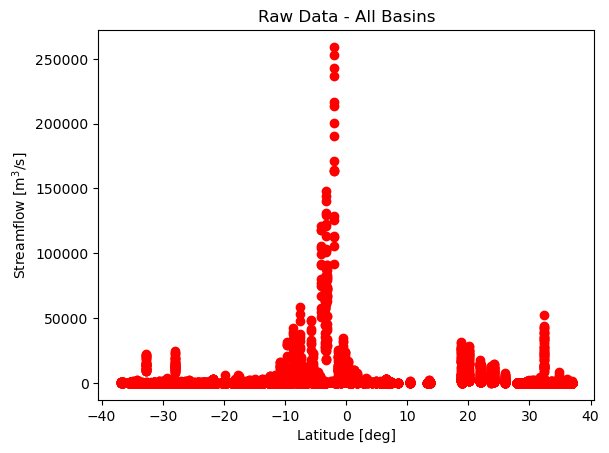

In [8]:
plt.scatter(lat,q,color='r')
plt.title('Raw Data - All Basins')
plt.xlabel('Latitude [deg]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU

lat = (lat*np.pi)/180
# Convert q and swe to NumPy arrays
scaled = scaled.to_numpy()  # Assume scaled is a pandas Series
area = area.to_numpy()      # Assume area is a pandas Series
lat = lat.to_numpy()
y = q.to_numpy()            # Target variable

# Step 1: Replace zeros with a small value
scaled[scaled == 0] = 1e-9
area[area == 0] = 1e-9
lat[lat == 0] = 1e-9
y[y == 0] = 1e-9

# Step 2: Combine features into a 2D array
X = np.column_stack((scaled, area, lat))  # Shape will be (num_samples, 2)

# Step 3: Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [10]:
# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define the model
model = Sequential([
    Dense(128, input_dim=3, activation='leaky_relu'),
    # Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='leaky_relu'),
    Dropout(0.2),
    Dense(32, activation='leaky_relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
from tensorflow.keras.optimizers import RMSprop, Nadam
from tensorflow.keras.losses import Huber
model.compile(optimizer=Nadam(learning_rate=1e-3), loss=Huber(delta=0.1), metrics=['mae'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,  # High epochs with early stopping
    batch_size=128,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)

/global/home/users/arvalcarcel/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-19 02:27:28.188914: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.4803e-04 - mae: 0.0131 - val_loss: 1.2119e-04 - val_mae: 0.0041 - learning_rate: 0.0010
Epoch 2/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3093e-04 - mae: 0.0053 - val_loss: 1.0217e-04 - val_mae: 0.0049 - learning_rate: 0.0010
Epoch 3/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1658e-04 - mae: 0.0049 - val_loss: 9.8054e-05 - val_mae: 0.0053 - learning_rate: 0.0010
Epoch 4/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1904e-04 - mae: 0.0050 - val_loss: 8.0601e-05 - val_mae: 0.0042 - learning_rate: 0.0010
Epoch 5/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8497e-05 - mae: 0.0045 - val_loss: 7.0182e-05 - val_mae: 0.0033 - learning_rate: 0.0010
Epoch 6/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5852e-05 - mae: 0.0046 - val_loss: 6.1675e-05 - val_mae: 0.0027 - learning_rate: 0.0010
Epoch 7/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.4062e-05 - mae: 0.0042 - val_lo

In [12]:
# Step 7: Evaluate
test_loss = model.evaluate(X_test, y_test)
print(f"Test MAPE: {test_loss}")

# Step 8: Predict
predictions = model.predict(X_test)
y_pred = scaler_y.inverse_transform(predictions)

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5401e-05 - mae: 0.0024  
Test MAPE: [4.0399427234660834e-05, 0.0020736991427838802]
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


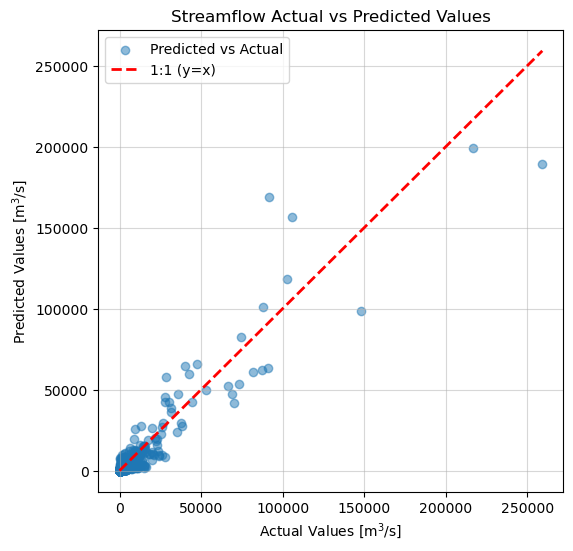

In [13]:
# Step 1: Predict values
y_pred = model.predict(X_test)
# y_pred = np.expm1(y_pred)

# Step 2: Create the scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test*max(y), y_pred*max(y), alpha=0.5, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 (y=x)', linewidth=2)

# Step 3: Add labels, title, and legend
plt.title("Streamflow Actual vs Predicted Values")
plt.xlabel("Actual Values [m${^3}$/s]")
plt.ylabel("Predicted Values [m${^3}$/s]")
plt.legend()
# plt.xlim(0,25000)
# plt.ylim(0,25000)
plt.grid(alpha=0.5)

# Step 4: Show the plot
plt.show()

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


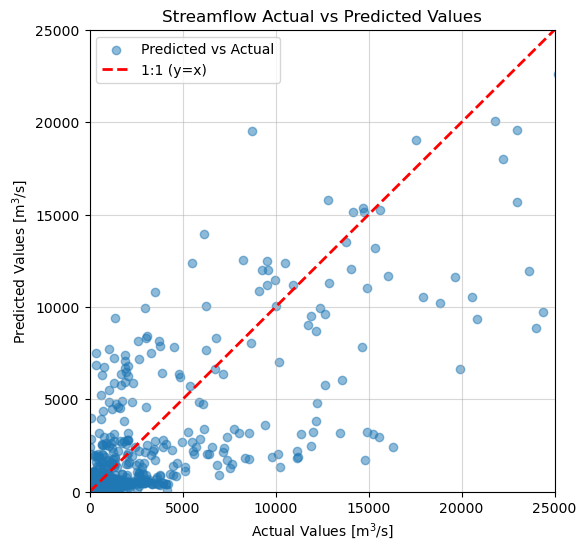

In [14]:
# Step 1: Predict values
y_pred = model.predict(X_test)
# y_pred = np.expm1(y_pred)

# Step 2: Create the scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test*max(y), y_pred*max(y), alpha=0.5, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 (y=x)', linewidth=2)

# Step 3: Add labels, title, and legend
plt.title("Streamflow Actual vs Predicted Values")
plt.xlabel("Actual Values [m${^3}$/s]")
plt.ylabel("Predicted Values [m${^3}$/s]")
plt.legend()
plt.xlim(0,25000)
plt.ylim(0,25000)
plt.grid(alpha=0.5)

# Step 4: Show the plot
plt.show()

In [15]:
# Extract loss and validation loss from the training history
test_values = y_test*max(y)
pred_values = y_pred*max(y)

test_values = np.ravel(test_values)
pred_values = np.ravel(pred_values)

# Create a new DataFrame
pred_df = pd.DataFrame({
    'Test Values': test_values,
    'Predicted Values': pred_values
})

file_path =  '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/test_vs_pred_values.csv'

# Export to a CSV file
# pred_df.to_csv(file_path, index=False)

from sklearn.metrics import r2_score

# Assuming test_values and pred_values are 1D arrays or lists
r_squared = r2_score(test_values, pred_values)
print(f"R-squared value: {r_squared}")


R-squared value: 0.8813039560465334


Mean Squared Error (MSE): 9.952918919971658e-05


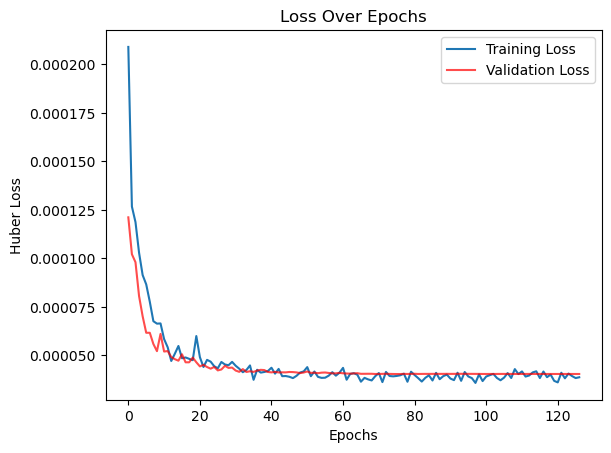

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Extract loss and validation loss from the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a new DataFrame
loss_df = pd.DataFrame({
    'Epoch': range(1, len(training_loss) + 1),  # Adding epoch numbers
    'Training Loss': training_loss,
    'Validation Loss': validation_loss
})

file_path =  '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/training_validation_losses.csv'

# Export to a CSV file
loss_df.to_csv(file_path, index=False)

# print((max(y_train) - min(y_train))**2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss',color='r',alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')
plt.title('Loss Over Epochs')
# plt.ylim(0.00001, 0.0002)
plt.legend()
plt.show()


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


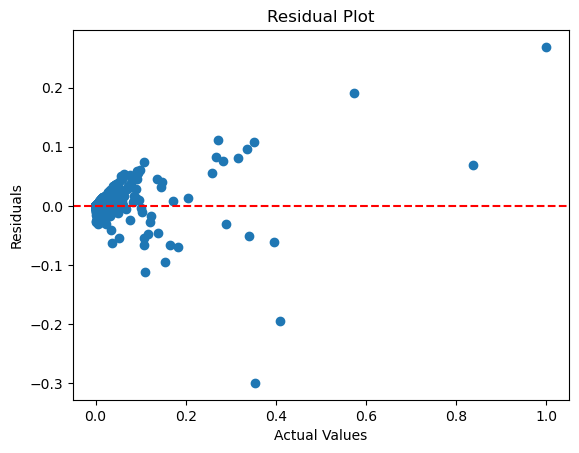

In [17]:
import matplotlib.pyplot as plt

residuals = y_test - model.predict(X_test)
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


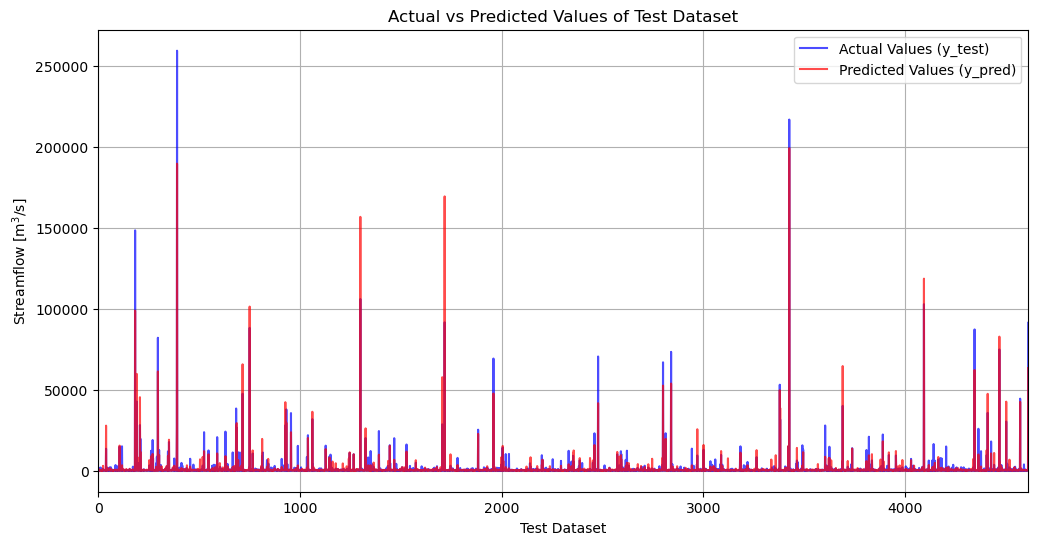

In [18]:
# Plot y_test and y_pred as a time series
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test*max(y), label="Actual Values (y_test)", color="blue", alpha=0.7)
plt.plot(np.arange(len(y_pred)), y_pred*max(y), label="Predicted Values (y_pred)", color="red", alpha=0.7)
plt.title("Actual vs Predicted Values of Test Dataset")
plt.xlabel("Test Dataset")
plt.ylabel("Streamflow [m${^3}$/s]")
plt.xlim(0,len(y_test))
plt.legend()
plt.grid(True)
plt.show()

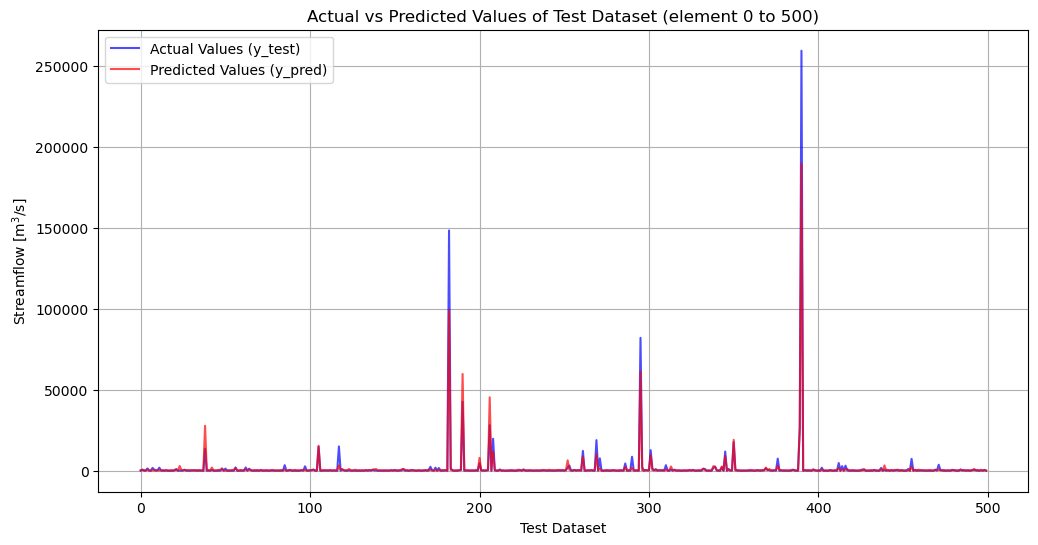

In [19]:
# Plot y_test and y_pred as a time series
plt.figure(figsize=(12, 6))
plt.plot((np.arange(len(y_test)))[0:500], (y_test*max(y))[0:500], label="Actual Values (y_test)", color="blue", alpha=0.7)
plt.plot((np.arange(len(y_pred)))[0:500], (y_pred*max(y))[0:500], label="Predicted Values (y_pred)", color="red", alpha=0.7)

# Add titles and labels
plt.title("Actual vs Predicted Values of Test Dataset (element 0 to 500)")
plt.xlabel("Test Dataset")
plt.ylabel("Streamflow [m${^3}$/s]")
# plt.xlim(0,len(y_test))
plt.legend()
plt.grid(True)
plt.show()

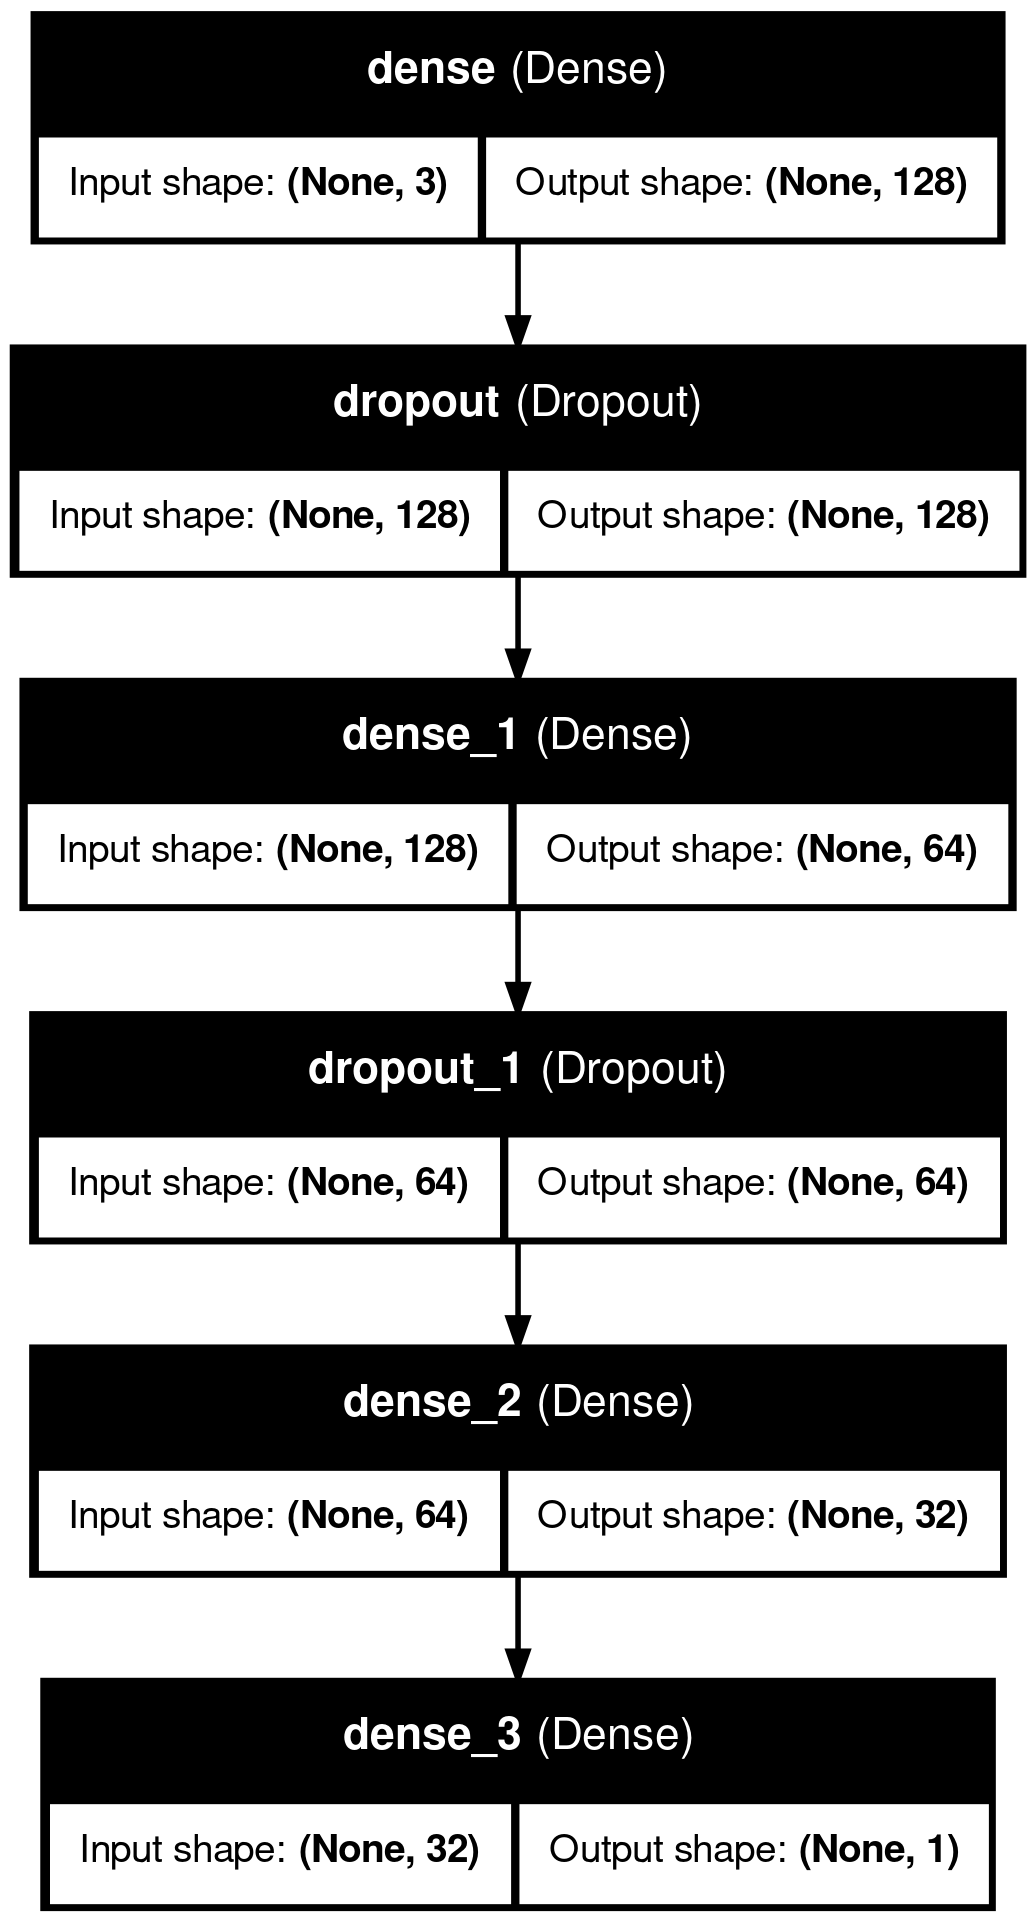

In [20]:
filename = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rnn_plot.png'
# Ensure the directory exists
os.makedirs(os.path.dirname(filename), exist_ok=True)
from tensorflow.keras.utils import plot_model

# Plot and save the model
plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(filename)